In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable

import numpy as np
import cvxpy as cp

from free_flyer.free_flyer import FreeFlyer
import pickle, os

In [6]:
#load train/test data
prob = FreeFlyer() #use default config, pass different config file oth.
config_fn = './free_flyer/config/default.p'

config_file = open(config_fn,'rb')
dataset_name, _, _ = pickle.load(config_file); config_file.close()

relative_path = os.getcwd()
dataset_fn = relative_path + '/free_flyer/data/' + dataset_name

train_file = open(dataset_fn+'/train.p','rb')
# p_train, x_train, u_train, y_train, c_train, times_train = pickle.load(train_file)
train_data = pickle.load(train_file)
train_file.close()
x_train = train_data[1]
y_train = train_data[3]

test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test, c_test, times_test = test_data
test_file.close()

n_test = x_test.shape[0]

# task-specific MLOPT

In [20]:
from solvers.mlopt_ff import MLOPT_FF

In [21]:
system = 'free_flyer'
prob_features = ['x0', 'obstacles']
mlopt_ts_obj = MLOPT_FF(system, prob, prob_features)

n_features = 4 + 4*prob.n_obs + prob.n_obs
mlopt_ts_obj.construct_strategies(n_features, train_data)
print(mlopt_ts_obj.n_strategies)

430


In [22]:
mlopt_ts_obj.setup_network()

fn_saved = 'models/mloptff_free_flyer_20200702_1648.pt'
mlopt_ts_obj.load_network(fn_saved)

mlopt_ts_obj.model

Loading presaved classifier model from models/mloptff_free_flyer_20200702_1648.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=44, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=430, bias=True)
  )
)

In [ ]:
mlopt_ts_obj.training_params['TRAINING_ITERATIONS'] = 100
mlopt_ts_obj.train(verbose=True)
print(mlopt_ts_obj.model_fn)

In [ ]:
n_succ = 0
count = 0
gurobi_mlopt_fail = 0

costs_mlopt = []
total_time_mlopt = []
num_solves_mlopt = []

cost_ratios_mlopt = []

for ii in range(n_test):
    if ii % 1000 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals = mlopt_ts_obj.forward(prob_params)
        

        count += 1
        if prob_success:
            n_succ += 1
            costs_mlopt += [cost]
            total_time_mlopt += [total_time]
            num_solves_mlopt += [n_evals]

            true_cost = c_test[ii]
            cost_ratios_mlopt += [cost / true_cost]
    except:
        print('Solver failed at {}'.format(ii))
        gurobi_mlopt_fail += 1
        continue

costs_mlopt = np.array(costs_mlopt)
cost_ratios_mlopt = np.array(cost_ratios_mlopt)
total_time_mlopt = np.array(total_time_mlopt)
num_solves_mlopt = np.array(num_solves_mlopt, dtype=int)

mlopt_percentage = 100 * float(n_succ) / float(count)
mlopt_percentage

0 / 10000


# image encodings

In [4]:
from solvers.mlopt_ff import MLOPT_FF

In [5]:
system = 'free_flyer'
prob_features = ['x0', 'obstacles_map']

mlopt_cnn = MLOPT_FF(system, prob, prob_features)

n_features = 4
mlopt_cnn.construct_strategies(n_features, train_data)
print(mlopt_cnn.n_strategies)

430


In [7]:
mlopt_cnn.setup_network()

fn_saved = 'models/mloptff_free_flyer_20200706_0823.pt'
mlopt_cnn.load_network(fn_saved)

mlopt_cnn.model

Loading presaved classifier model from models/mloptff_free_flyer_20200706_0823.pt


CNNet(
  (conv_activation): ReLU()
  (ff_activation): ReLU()
  (conv_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  )
  (ff_layers): ModuleList(
    (0): Linear(in_features=260, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=430, bias=True)
  )
)

In [ ]:
mlopt_cnn.training_params['TRAINING_ITERATIONS'] = 500
mlopt_cnn.train(train_data=train_data, verbose=False)

In [15]:
prob_params = {}
idx = np.random.randint(test_data[1].shape[0])
for k in p_test.keys():
    prob_params[k] = p_test[k][idx]

prob_success, cost, total_time, n_evals = mlopt_cnn.forward(prob_params)

if prob_success:
    print(cost)
else:
    print('Failed')

0.4542820344632411


In [ ]:
n_succ = 0
count = 0

costs_cnn = []
total_time_cnn = []
num_solves_cnn = []

cost_ratios_cnn = []
costs_ip = []
total_time_ip = []
num_solves_ip = []

for ii in range(n_test):
    if ii % 1000 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals = mlopt_cnn.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_cnn += [cost]
            total_time_cnn += [total_time]
            num_solves_cnn += [n_evals]

            true_cost = c_test[ii]
            costs_ip += [true_cost]
            total_time_ip += [times_test[ii]]

            cost_ratios_cnn += [cost / true_cost]
    except:
        print('Solver failed at {}'.format(ii))
        continue

costs_cnn = np.array(costs_cnn)
cost_ratios_cnn = np.array(cost_ratios_cnn)
total_time_cnn = np.array(total_time_cnn)
num_solves_cnn = np.array(num_solves_cnn, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)
num_solves_ip = np.array(num_solves_ip, dtype=int)

cnn_percentage = 100 * float(n_succ) / float(count)
cnn_percentage

# Results

In [ ]:
import math
import seaborn as sns
sns.set(font_scale=1.5, font="serif", style="whitegrid")
import pandas as pd

flierprops = {'alpha':0.2}

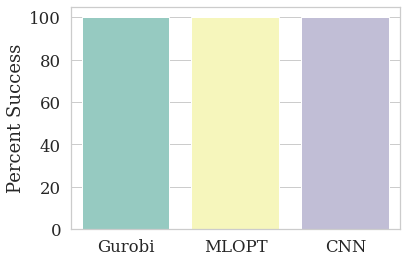

In [25]:
results = {'Gurobi':[100.], 'MLOPT':[mlopt_percentage], 'CNN':[cnn_percentage]}
results = pd.DataFrame(results)

ax1 = sns.barplot(data=results, palette="Set3", label='small')
ax1.set(xlabel="", ylabel="Percent Success")

plt.tight_layout()

figure = ax1.get_figure()
# # figure.savefig("loss.pdf")

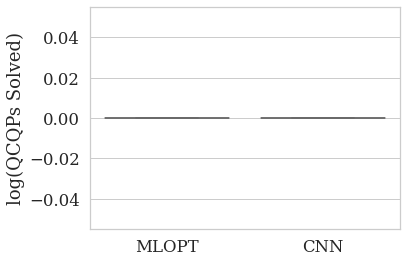

In [26]:
results = {}
results['Policy'] = ['MLOPT']*len(num_solves_mlopt) + ['CNN']*len(num_solves_cnn)
results['Solves'] = np.hstack((np.log10(num_solves_mlopt), np.log10(num_solves_cnn)))
results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Solves'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="log(QCQPs Solved)")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("loss.pdf")

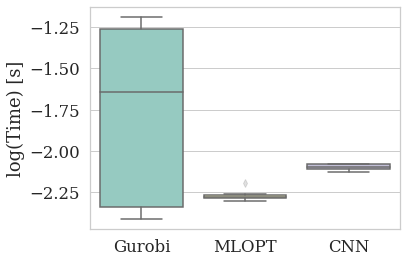

In [28]:
results = {}
results['Policy'] = ['Gurobi']*len(total_time_ip) + ['MLOPT']*len(total_time_mlopt) + \
    ['CNN']*len(total_time_cnn)
results['Time'] = np.hstack((np.log10(total_time_ip), \
    np.log10(total_time_mlopt), np.log10(total_time_cnn)))
results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Time'], palette="Set3", flierprops=flierprops)
ax1.set(xlabel="", ylabel="log(Time) [s]")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("loss.pdf")

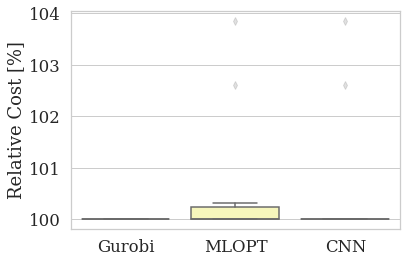

In [29]:
results = {}
results['Policy'] = ['Gurobi']*len(costs_ip) + \
    ['MLOPT']*len(cost_ratios_mlopt) + ['CNN']*len(cost_ratios_cnn)
results['Costs'] = np.hstack((100*np.ones(len(costs_ip)), \
    100*cost_ratios_mlopt, 100*cost_ratios_cnn))
results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Costs'], palette="Set3", flierprops=flierprops)
ax1.set(xlabel="", ylabel="Relative Cost [%]")

plt.tight_layout()
# plt.ylim(0, int(math.ceil(np.max(np.maximum(costs_ip, costs_naive_mlopt, costs_mlopt)) / 10.0)) * 10)

figure = ax1.get_figure()
# figure.savefig("loss.pdf")